In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

In [3]:
# d dimensional Gaussian
def Gaussian_ND(x, mu, sigma):

    d = len(mu)
    
    sigmaInv = np.linalg.pinv(sigma)
    
    first_part = 1/(np.sqrt( (2*np.pi)**(d) * np.linalg.det(sigma)) )
    exp_term = -0.5*(x-mu).T @ sigmaInv @ (x-mu)
    
    return first_part*np.exp(exp_term)

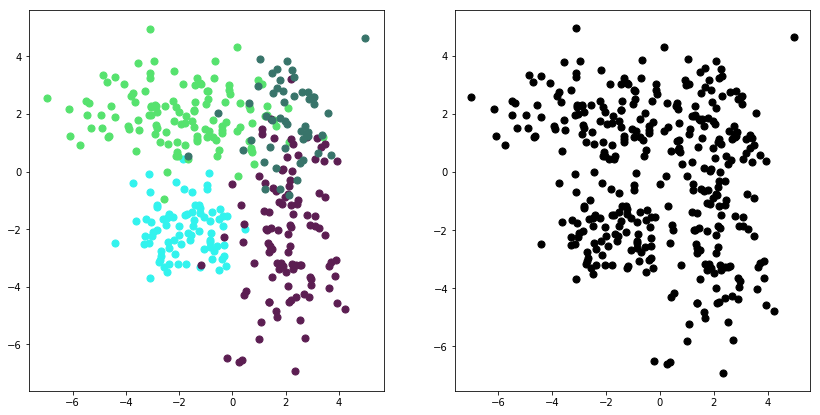

In [4]:
# Ground truth number of clusters
gt_k = 4

# Random colors for the clusters
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(gt_k)]

# Ground truth mus (means/centers) of the clusters
gt_mus = np.array([[-2,-2], [-2,2], [2,-2], [2,2]])

# Ground truth covariance matrices
gt_sigma_1 = np.array([[1, 0], [0, 1]]) # Isotropic (circular) (bottom left)
gt_sigma_2 = np.array([[5, 0], [0, 1]]) # Very anisotropic in x  (top left)
gt_sigma_3 = np.array([[1, 0], [0, 4]]) # Very Anisotropic in y (bottom right)
gt_sigma_4 = np.array([[1, 0], [0, 2]]) # Anisotropic in y (top right)

# Package the ground truth covariance into a single array
gt_sigmas = np.array([gt_sigma_1, gt_sigma_2, gt_sigma_3, gt_sigma_4])

# The number of data points per cluster
gt_num_pts = [80, 120, 104, 50]

# Generate random Gaussian data given the means and covariance matrices
d1 = np.random.multivariate_normal(gt_mus[0], gt_sigmas[0], gt_num_pts[0])
d2 = np.random.multivariate_normal(gt_mus[1], gt_sigmas[1], gt_num_pts[1])
d3 = np.random.multivariate_normal(gt_mus[2], gt_sigmas[2], gt_num_pts[2])
d4 = np.random.multivariate_normal(gt_mus[3], gt_sigmas[3], gt_num_pts[3])

# Concatenate all the data and shuffle up the data
all_data = [d1, d2, d3, d4]
all_data = np.vstack(all_data)
np.random.shuffle(all_data)

plt.figure(figsize=(14,7))

# The original ground truth data with known classes
plt.subplot(1,2,1)
plt.scatter(d1[:,0], d1[:,1], s=50, c=colors[0])
plt.scatter(d2[:,0], d2[:,1], s=50, c=colors[1])
plt.scatter(d3[:,0], d3[:,1], s=50, c=colors[2])
plt.scatter(d4[:,0], d4[:,1], s=50, c=colors[3])

# The way the unlabeled  data looks to the algorithm 
plt.subplot(1,2,2)
plt.scatter(all_data[:,0], all_data[:,1], s=50, c='k')

In [5]:
# K-means

# Choose number of clusters
k = 4

# Choose initial clusters
num_data_pts = len(all_data)
centroids = np.zeros((k, 2))

# The data is shuffled, let's take the first four data points
for i in range(0, k):
    centroids[i,:] = all_data[i,:]

# Array to determine which class each observation belongs to 0-(k-1)
classes = np.zeros((num_data_pts,1), np.int)
prev_classes = np.zeros((num_data_pts,1), np.int)

# Start the iterative process
converged = False

iters = 1

while not converged and iters < 10:
  
    # Assign each observation to nearest centroid
    for i in range(0, len(all_data)):
        
        cur_pt = all_data[i]
        dist_to_centroid = 1e6
        new_class = -1
        
        # Check for the closest centroid
        for j in range(0, k):
            
            cur_centroid = centroids[j]
            
            # Calculate Euclidean distance
            cur_distance = math.sqrt((cur_pt[0]-cur_centroid[0])**2 + (cur_pt[1]-cur_centroid[1])**2)
            if (cur_distance < dist_to_centroid):
                dist_to_centroid = cur_distance
                new_class = j
        
        classes[i] = new_class
        
    # Update centroids
    centroids = np.zeros((k,2))
    num_in_each_class = np.zeros((k,1))
    for i in range(0, len(all_data)):
        
        cur_pt = all_data[i]
        cur_class = classes[i]
        
        centroids[cur_class,0] += cur_pt[0]
        centroids[cur_class,1] += cur_pt[1]
        
        num_in_each_class[cur_class] += 1
        
    # Centroid is the average of coordinates - so divide by the number of points
    for i in range(0, k):
        
        centroids[i,:] /= num_in_each_class[i]
            
    iters += 1
    
    # Check if there were cluster reassingments
    diff = np.sum(np.abs(classes-prev_classes))
    if (diff == 0):   
        converged = True
        
    prev_classes = classes.copy()    

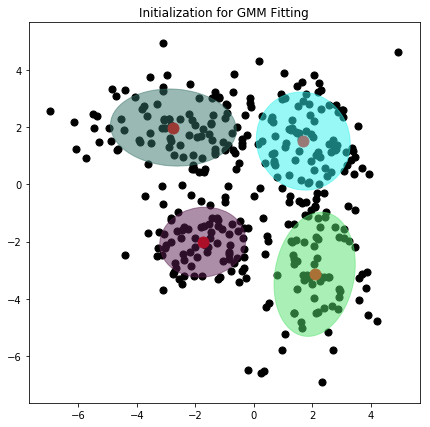

In [6]:
################################################################
# START COMMENTING HERE
################################################################

#count the number of data points belonging to each cluster
#equivalent to N sub k
k = 4

num_per_class = np.zeros((k,1), np.float32)
for c in range(0, len(all_data)):
    cur_class = classes[c]
    num_per_class[cur_class] += 1

#calculate pi sub k which is the fraction of data points each cluster contains
#by dividing the number of data points per class by the total number of data points
piks = num_per_class/len(all_data)

#initialize the means by taking each existing centroid from every cluster
means = dict()
for c in range(0, k):
    means[c] = centroids[c]

#initialize covariances to 0
covariances = dict()
for c in range(0, k):
    covariances[c] = np.array([[0,0], [0,0]], np.float32)

#calculate the covariance within each cluster
#first, subtract the means (centroid) of each cluster from each data point that is in said cluster
#caclulate the dot product of the resulting difference and its transpose
#finally, divide the covariance of each cluster by each resulting product
#to obtain the new covariances
for c in range(0, k):
    for d in range(0, len(all_data)):
        
        if (classes[d] != c):
            continue
            
        diff = (all_data[d] - means[c])
        diff.shape = (len(all_data[d]), 1)
        covariances[c] += diff.dot(diff.T)

    covariances[c] /= (num_per_class[c]-1)

#setup variables to plot the new data
fig1 = plt.figure(figsize = (7,7))
splot = plt.subplot(1, 1, 1)

#plot all data as a scatter plot
for i in range(0, len(all_data)):

    plt.scatter(all_data[i,0], all_data[i,1], s=50, c='k')

#using the covariances and their eigenvalues, calculate the approximate area covered by each cluster
#represented by elipses
#this plot corresponds to the clusters with initialized parameters, inluding means as centroids
for i in range(0, k):
    
    cur_mean = means[i]
    plt.scatter(cur_mean[0], cur_mean[1], s=120, c='r')
    plt.title('Initialization for GMM Fitting')
    
    v, w = np.linalg.eigh(covariances[i])
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi
    ell = mpl.patches.Ellipse(cur_mean, v[0], v[1], 180. + angle, color=colors[i])
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [7]:
#intialize parameters for the gmm algorithm
#these include: number of iterations, log likelihood, and two convergence parameters
#the log likelihoods are to be compared at each step with epsilon, which indicates whether convergence has occurred or not
#goal of this algorithm is to maximize the log likelihood
iters = 1
max_iters = 200
prev_log_likelihood = 1e6
converged = False
convergence_epsilon = 1e-3

#initialize a matrix with the shape of the data and k, populated with zeros
#to be populated by gaussians created with the current means and covariance parameters at each step
gammaks = np.zeros((len(all_data),k), np.float32)

#execute algorithm while total number of iterations has not been reached
#and while convergence has not been achieved
while iters < max_iters and not converged:
   
    #populate the intialized matrix with a gaussian based on the centroid and covariance and multiplied 
    #by the fraction of data points corresponding to the current cluster
    #this is done for each point in the data and each cluster
    for d in range(0, len(all_data)):
        for c in range(0, k):
            gammaks[d,c] = Gaussian_ND(all_data[d], means[c], covariances[c])*piks[c]
    
    #the gaussians for each cluster at each point are divided by their sum
    #which corresponds to the formula for calculating gamma sub k
    #these values indicate the degree to which each cluster would have been responsible for generating each data point
    #this is equivalent to the expectation step of the algorithm
    for d in range(0, len(all_data)):
        gammaks[d,:] /= np.sum(gammaks[d,:])
        
    #calculate a number of data points per cluster based on the newly obtained expectation
    Nk = np.zeros((k,1), np.float)
    for c in range(0,k):
        Nk[c] = np.sum(gammaks[:,c])
    
    #initialize new parameters which will be used to store the recalculation of the means and
    #covariance for each cluster
    new_means = dict()
    new_covariances = dict()
    for i in range(0, k):
        new_means[i] = np.array((0,0), np.float32)
        new_covariances[i] = np.array([[0,0], [0,0]], np.float32)
        
    #the following steps correspond to the maximization part of the algorithm
    #recalculate the means and covariance using the same forumal as before, except that the 
    #generated expectation values are used to obtain the new centroids, which then results in new covariances as well
    for c in range(0,k):
        for d in range(0, len(all_data)):
            new_means[c] += (1/Nk[c]) * gammaks[d,c]*all_data[d]
            
            diff = (all_data[d] - means[c])
            diff.shape = (len(all_data[d]), 1)
            new_covariances[c] += (1/Nk[c])*gammaks[d,c]*diff.dot(diff.T)
         
    #recalculate the fraction of data points per cluster, using the newly obtained number of data points per cluster
    new_piks = np.zeros((k,1))
    for c in range(0,k):
        new_piks[c] = Nk[c]/len(all_data)
    
    #store the newly calculated parameters
    means = new_means
    covariances = new_covariances
    piks = new_piks
   
    #initailize log likelihood
    log_likelihood = 0
    
    #calculate the log likelihood by first summing each gaussian k for each data point multiplying by the
    #fraction of data points per cluster
    #the negative log of the resulting value is taken and added to the current log likelihood
    #this step is to setup for estimating whether convergence has been reached or not
    for d in range(0, len(all_data)):
        k_sum = 0
        for c in range(0, k):
            k_sum += piks[c] * Gaussian_ND(all_data[d], means[c], covariances[c])
    
        log_likelihood += -np.log(k_sum)
        
    #output the current iteration number and log likelihood
    iteration_info = 'Iteration %0.3d: Log likelihood = %0.3f' %(iters, log_likelihood)
    print(iteration_info)
        
    #check whether the difference of the current log likelihood and previous one has fallen below the epsilon parameter
    #this is equivalent to minimizing the negative log likelihood, which is also the same as
    #log likelihood maximization
    #if the conditions are met, convergence has been achieved the algorithm stops
    if (np.abs(log_likelihood - prev_log_likelihood) < convergence_epsilon):
        print('   *** Optimization has converged ***')
        converged = True
    
    #set the previous log likelihood to the current one, add one to the current iteration number and repeat the above steps
    prev_log_likelihood = log_likelihood
    
    iters += 1

Iteration 001: Log likelihood = 1540.430
Iteration 002: Log likelihood = 1539.550
Iteration 003: Log likelihood = 1539.059
Iteration 004: Log likelihood = 1538.695
Iteration 005: Log likelihood = 1538.398
Iteration 006: Log likelihood = 1538.149
Iteration 007: Log likelihood = 1537.940
Iteration 008: Log likelihood = 1537.767
Iteration 009: Log likelihood = 1537.624
Iteration 010: Log likelihood = 1537.507
Iteration 011: Log likelihood = 1537.412
Iteration 012: Log likelihood = 1537.335
Iteration 013: Log likelihood = 1537.273
Iteration 014: Log likelihood = 1537.223
Iteration 015: Log likelihood = 1537.182
Iteration 016: Log likelihood = 1537.148
Iteration 017: Log likelihood = 1537.121
Iteration 018: Log likelihood = 1537.099
Iteration 019: Log likelihood = 1537.080
Iteration 020: Log likelihood = 1537.064
Iteration 021: Log likelihood = 1537.051
Iteration 022: Log likelihood = 1537.040
Iteration 023: Log likelihood = 1537.030
Iteration 024: Log likelihood = 1537.022
Iteration 025: L

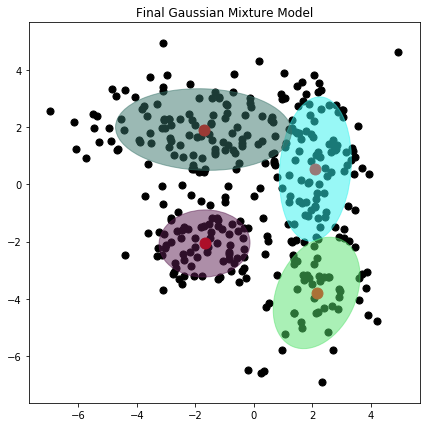

In [8]:
#setup to plot the new clusters
fig1 = plt.figure(figsize = (7,7))
splot = plt.subplot(1, 1, 1)

#create a scatter plot of all the data
for i in range(0, len(all_data)):

    plt.scatter(all_data[i,0], all_data[i,1], s=50, c='k')
    
#using the resulting means and covariances for each cluster obtained from the gmm algorithm
#the estimated coverage of each cluster is calculated and plotted over the data, represented by ellipses
#using the same steps applied when the parameters were first initialized
#this shows the resulting gaussian mixture model after running the algorithm using k clusters
#and the above mentioned parameters
for i in range(0, k):
    
    cur_mean = means[i]
    plt.scatter(cur_mean[0], cur_mean[1], s=120, c='r')
    plt.title('Final Gaussian Mixture Model')
    
    v, w = np.linalg.eigh(covariances[i])
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi
    ell = mpl.patches.Ellipse(cur_mean, v[0], v[1], 180. + angle, color=colors[i])
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [32]:
#find hard labels for each point in the data
#for each data point, use the formula to calculate the negative log likelihood of that point belonging to each cluster
#take the miniumum value of these likelihoods and assign its corresponding cluster as the label for that point
#taking the minimum negative log likelihood is the same as taking the max nonnegative log likelihood
lk = []
for d in range(0, len(all_data)):
        dk = []
        for c in range(0, k):
            lglk = piks[c] * Gaussian_ND(all_data[d], means[c], covariances[c])
            dk.append(-np.log(lglk))
        ind = dk.index(min(dk))
        lk.append(ind)
print(lk)

[0, 0, 3, 3, 0, 3, 2, 0, 2, 3, 2, 0, 2, 2, 3, 0, 2, 2, 3, 0, 0, 2, 3, 0, 2, 0, 2, 0, 0, 1, 3, 0, 0, 3, 0, 0, 3, 2, 1, 3, 1, 3, 3, 0, 2, 2, 0, 3, 3, 3, 1, 0, 3, 2, 3, 2, 0, 3, 3, 2, 3, 0, 3, 2, 0, 2, 2, 0, 1, 3, 2, 3, 3, 2, 3, 1, 0, 2, 0, 0, 3, 1, 3, 2, 3, 3, 1, 2, 3, 2, 2, 2, 0, 0, 3, 3, 1, 3, 0, 0, 2, 0, 3, 2, 2, 0, 3, 0, 3, 0, 0, 3, 2, 3, 2, 1, 3, 0, 0, 3, 3, 2, 0, 1, 0, 3, 2, 0, 2, 3, 1, 3, 3, 0, 3, 3, 1, 0, 3, 3, 2, 2, 2, 0, 3, 2, 0, 2, 1, 3, 1, 1, 3, 3, 0, 3, 3, 0, 2, 0, 0, 3, 3, 3, 0, 2, 2, 2, 3, 3, 0, 0, 0, 2, 2, 0, 1, 3, 3, 3, 3, 1, 1, 3, 0, 2, 0, 3, 3, 0, 3, 2, 3, 0, 1, 3, 0, 0, 2, 0, 1, 1, 0, 3, 2, 3, 3, 1, 2, 1, 1, 3, 2, 0, 2, 0, 2, 1, 1, 1, 3, 3, 2, 3, 3, 2, 0, 3, 0, 1, 2, 0, 3, 1, 0, 2, 3, 2, 1, 1, 0, 0, 0, 2, 0, 0, 3, 3, 2, 0, 0, 1, 3, 3, 2, 3, 1, 2, 1, 3, 2, 0, 3, 0, 0, 1, 3, 3, 3, 1, 2, 3, 0, 3, 1, 3, 2, 3, 0, 2, 0, 0, 0, 1, 1, 0, 3, 3, 0, 2, 1, 3, 3, 3, 2, 2, 0, 2, 3, 2, 2, 3, 3, 2, 3, 0, 0, 1, 0, 0, 0, 1, 0, 3, 2, 1, 3, 0, 0, 2, 2, 3, 3, 0, 3, 2, 1, 3, 0, 2, 1, 3, 3, 

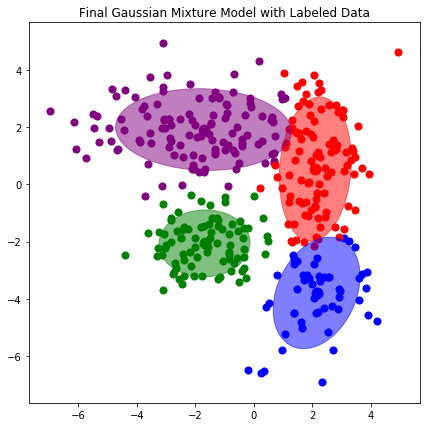

In [34]:
#setup to plot the new clusters
fig1 = plt.figure(figsize = (7,7))
splot = plt.subplot(1, 1, 1)

#assign colors for each cluster
colors = ['red','blue','green','purple']
cs = []
#create an array the same size as the data which contains a color value corresponding to each data point
#based on the cluster each particular data point belongs to
for i in range(len(lk)):
    for j in range(k): 
        if lk[i] == j:
            cs.append(colors[j])
#plot the data while calculating the area covered by each cluster
for i in range(0, len(all_data)):

    plt.scatter(all_data[i,0], all_data[i,1], s=50, c=cs[i])
    
#using the resulting means and covariances for each cluster obtained from the gmm algorithm
#the estimated coverage of each cluster is calculated and plotted over the data, represented by ellipses
#using the same steps applied when the parameters were first initialized
#this shows the resulting gaussian mixture model after running the algorithm using k clusters
#and the above mentioned parameters
for i in range(0, k):
    
    cur_mean = means[i]
    plt.scatter(cur_mean[0], cur_mean[1], s=120, c=colors[i])
    plt.title('Final Gaussian Mixture Model with Labeled Data')
    
    v, w = np.linalg.eigh(covariances[i])
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi
    ell = mpl.patches.Ellipse(cur_mean, v[0], v[1], 180. + angle, color=colors[i])
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [29]:
print(all_data.shape[0])

354
